# Holiday Package Purchase Prediction

Dataset Source: https://www.kaggle.com/susant4learning/holiday-package-purchase-prediction

## Importing libraries and dataset

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SelectKBest, chi2
from imblearn import under_sampling, over_sampling

# Modelling libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier

# Evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
url = 'https://raw.githubusercontent.com/vincent-lim98/DS16_Final/main/travel.csv'
raw = pd.read_csv(url)

### Notes: As Data Science is an interative process, some of the EDA, preprocessing and feature engineering are results from iterative analytics too

# EDA & Preprocessing

In [3]:
# Quick look at the data
raw.sample(5)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
2784,202784,0,38.0,Self Enquiry,1,12.0,Small Business,Male,4,4.0,Deluxe,3.0,Married,2.0,0,3,0,1.0,Manager,25025.0
4159,204159,0,32.0,Company Invited,1,10.0,Small Business,Male,4,4.0,Standard,3.0,Married,2.0,0,4,1,1.0,Senior Manager,32353.0
4482,204482,1,56.0,Self Enquiry,1,9.0,Small Business,Male,4,4.0,King,NaN,Married,7.0,1,1,1,1.0,VP,38537.0
2232,202232,1,26.0,Company Invited,1,8.0,Salaried,Male,2,3.0,Basic,5.0,Married,7.0,1,5,0,0.0,Executive,17042.0
3547,203547,0,49.0,Self Enquiry,3,23.0,Salaried,Female,4,4.0,Deluxe,3.0,Married,2.0,0,4,1,1.0,Manager,25117.0


In [4]:
# Checking duplicates
print('There are', raw.duplicated().sum(), 'row(s) of duplicates')

There are 0 row(s) of duplicates


In [5]:
# Checking data types
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [6]:
# Checking skewness
raw.skew(axis = 0, skipna=True)

CustomerID                  0.000000
ProdTaken                   1.595763
Age                         0.382989
CityTier                    0.736531
DurationOfPitch             1.752037
NumberOfPersonVisiting      0.029817
NumberOfFollowups          -0.372719
PreferredPropertyStar       0.895545
NumberOfTrips               1.453884
Passport                    0.920980
PitchSatisfactionScore     -0.127726
OwnCar                     -0.495892
NumberOfChildrenVisiting    0.272199
MonthlyIncome               1.949160
dtype: float64

## Checking Correlation

<AxesSubplot:>

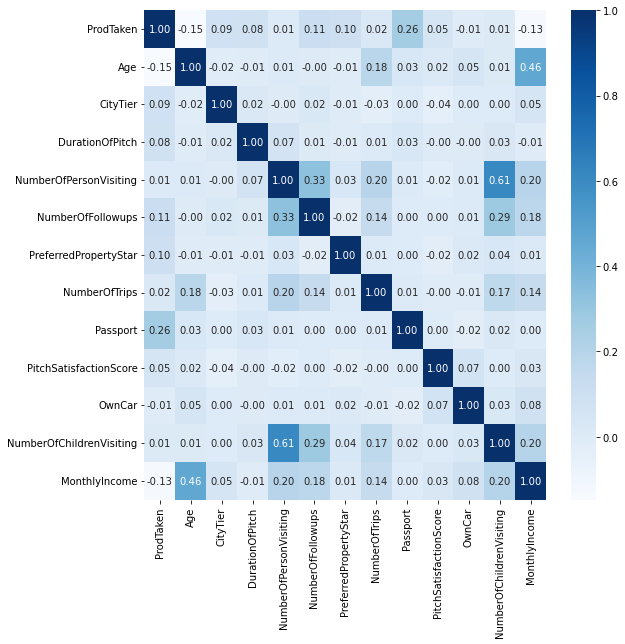

In [7]:
plt.figure(figsize=(9, 9))
raw = raw.drop(['CustomerID'],axis=1)
sns.heatmap(raw.corr(), cmap='Blues', annot=True, fmt='.2f')

After looking at the heat map, looks like there are no features with strong correlation with each other, the only noteable insight is 'NumberOfPersonVisiting' and 'NumberOfChildrenVisiting' could be redundant

### This is the code part to filter outliers but after testing the model, it turns out it is actually better to just keep the outliers

In [8]:
# print(f'Jumlah baris sebelum memfilter outlier: {len(raw)}')
# print(raw['ProdTaken'].value_counts())

# filtered_entries = np.array([True] * len(raw))
# for col in ['DurationOfPitch','MonthlyIncome','NumberOfTrips']:
#     Q1 = raw[col].quantile(0.25)
#     Q3 = raw[col].quantile(0.75)
#     IQR = Q3 - Q1
#     low_limit = Q1 - (IQR * 1.5)
#     high_limit = Q3 + (IQR * 1.5)

#     filtered_entries = ((raw[col] >= low_limit) & (raw[col] <= high_limit)) & filtered_entries
    
# raw = raw[filtered_entries]

# print('*'*50)
# print(f'Jumlah baris setelah memfilter outlier: {len(raw)}')
# print(raw['ProdTaken'].value_counts())

## Separating target variable which is 'ProdTaken'
ProdTaken define whether past customers took the product or not

In [9]:
# Create new dataframe for target variable
y = pd.DataFrame()
y['ProdTaken'] = raw['ProdTaken']

# CustomerID is not a variable and prodtaken is target
df_features = raw.drop(['ProdTaken'],axis=1)

## Data Cleaning

In [10]:
raw.isnull().sum()

ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

* Numericals data with median
* Categoricals data with mode

In [11]:
df = df_features.fillna(df_features.median())
df['TypeofContact'] = df['TypeofContact'].fillna(df['TypeofContact'].mode()[0])

# Looking at feature category below, these 4 are actually int type variables
df[['NumberOfChildrenVisiting','PreferredPropertyStar','NumberOfFollowups','NumberOfTrips']] = df[['NumberOfChildrenVisiting','PreferredPropertyStar','NumberOfFollowups','NumberOfTrips']].astype('int64')
# Looking at feature category below, there are 'Fe Male' values
df['Gender'] = df['Gender'].apply(lambda x: 'Female' if x=='Fe Male' else x)
# 'Divorced' and 'Unamrried' is ambigous but it should means they also don't have husband/wife and can be put into 'Single'
df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: 'Married' if x=='Married' else 'Single')

# Checking if there are missing values left
# df.info()

### Feature importance with chi square test

In [12]:
# We need to make all data numerical to test chi2 score
label = {'Self Enquiry':0,'Company Invited':1,
         'Salaried':0,'Free Lancer':1,'Small Business':2,'Large Business':3,
         'Female':0,'Male':1,
         'Deluxe':0,'Basic':1,'Standard':2,'Super Deluxe':3,'King':4,
         'Single':0,'Married':1,
         'Manager':0,'Executive':1,'Senior Manager':2,'AVP':3,'VP':4
        }

df_chi2 = df.copy()
for col in df_chi2.select_dtypes('object'):
        df_chi2.loc[:,col]=df_chi2[col].map(label)        
    
# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_chi2,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_chi2.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(18, 'Score'))

                       Specs         Score
17             MonthlyIncome  91649.503852
12                  Passport    235.825285
0                        Age    222.966448
3            DurationOfPitch    128.684162
10             MaritalStatus     36.621230
2                   CityTier     18.721582
7          NumberOfFollowups     16.332394
4                 Occupation     11.980290
1              TypeofContact      8.497068
9      PreferredPropertyStar      8.452716
13    PitchSatisfactionScore      7.822561
8             ProductPitched      3.392461
16               Designation      3.392461
11             NumberOfTrips      1.952874
5                     Gender      1.908758
14                    OwnCar      0.245803
15  NumberOfChildrenVisiting      0.192205
6     NumberOfPersonVisiting      0.081926


## Categorizing Features

In [13]:
# Numericals
num_dtypes = ['float64']
num_df = df.select_dtypes(include=num_dtypes)
nums = num_df.columns 
nums = [num for num in nums]

# Categoricals
cat_df = df.select_dtypes(exclude=num_dtypes)
cats = cat_df.columns
cats = [cat for cat in cats]

In [14]:
for i, col in enumerate(df[cats]):
    print(f'{i: <3}{col :-<25}{df[col].unique()}')

0  TypeofContact------------['Self Enquiry' 'Company Invited']
1  CityTier-----------------[3 1 2]
2  Occupation---------------['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
3  Gender-------------------['Female' 'Male']
4  NumberOfPersonVisiting---[3 2 1 4 5]
5  NumberOfFollowups--------[3 4 2 5 1 6]
6  ProductPitched-----------['Deluxe' 'Basic' 'Standard' 'Super Deluxe' 'King']
7  PreferredPropertyStar----[3 4 5]
8  MaritalStatus------------['Single' 'Married']
9  NumberOfTrips------------[ 1  2  7  5  6  3  4 19 21  8 20 22]
10 Passport-----------------[1 0]
11 PitchSatisfactionScore---[2 3 5 4 1]
12 OwnCar-------------------[1 0]
13 NumberOfChildrenVisiting-[0 2 1 3]
14 Designation--------------['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']


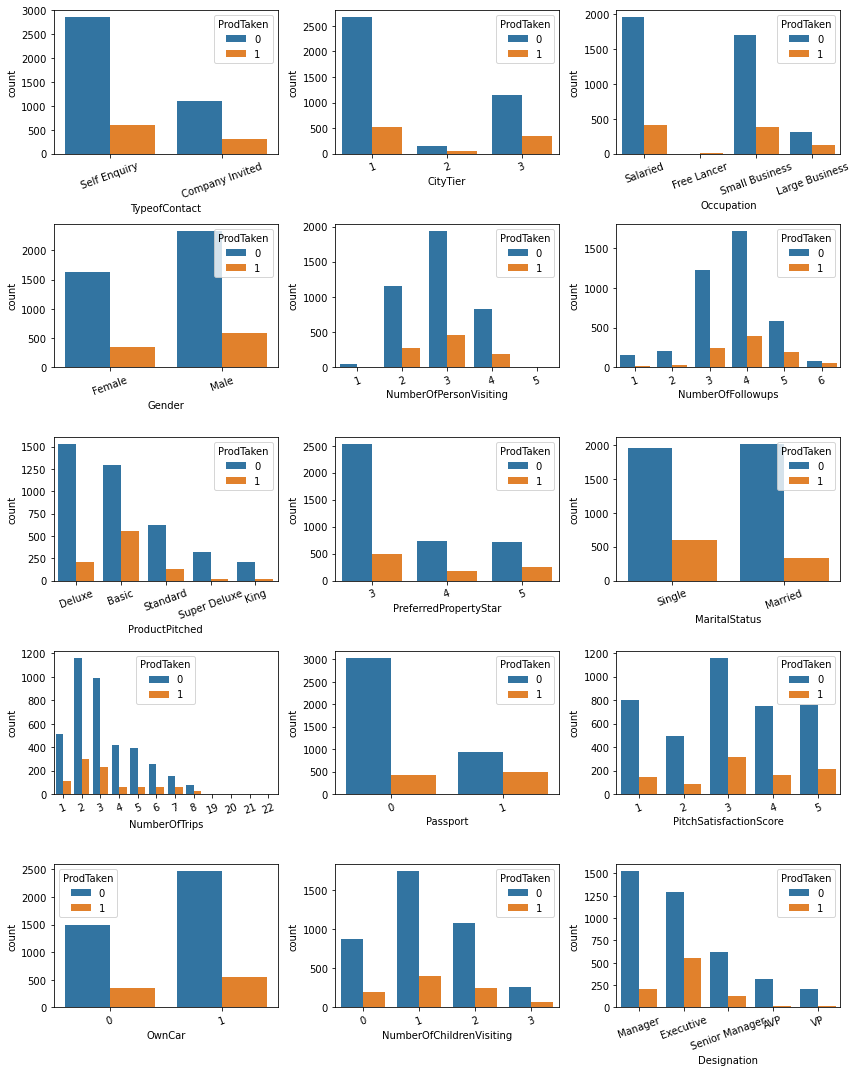

In [15]:
plt.figure(figsize=(12, 15))
for i, col in enumerate(df[cats]): 
    plt.subplot(5, 3, i+1);
    sns.countplot(df[col], hue=y['ProdTaken'])
    
    plt.xticks(rotation=20);
    plt.tight_layout()   

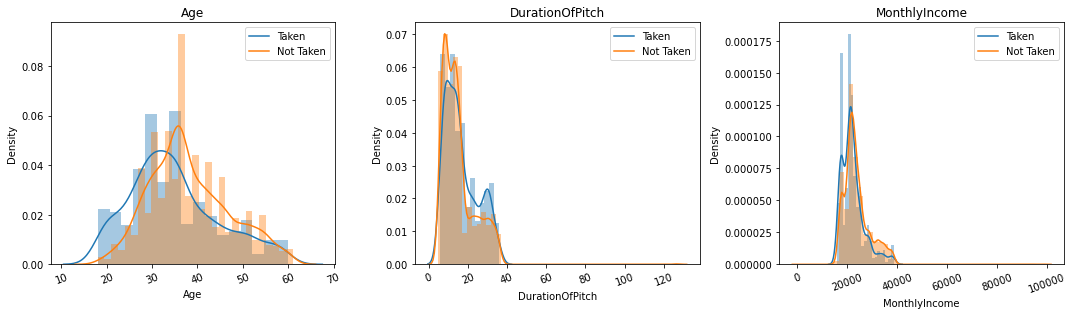

In [16]:
df_yes = df[nums][y['ProdTaken']==1]
df_no = df[nums][y['ProdTaken']==0]

plt.figure(figsize=(15, 8))
for i, col in enumerate(df[nums]): 
    plt.subplot(2, 3, i+1);
    sns.distplot(df_yes[col], label='Taken')
    sns.distplot(df_no[col], label='Not Taken')
    
    plt.xticks(rotation=20);
    plt.title(col);
    plt.legend(labels=['Taken','Not Taken'],fontsize='10')
    plt.tight_layout()   

## Encoding

In [17]:
# Look at the categorical data again to decide which encoding should be used
objects = df.select_dtypes(include=['object']).columns
for i, col in enumerate(df[objects]):
    print(f'{i:.<2}{col:-<25}{df[col].unique()}')

0.TypeofContact------------['Self Enquiry' 'Company Invited']
1.Occupation---------------['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
2.Gender-------------------['Female' 'Male']
3.ProductPitched-----------['Deluxe' 'Basic' 'Standard' 'Super Deluxe' 'King']
4.MaritalStatus------------['Single' 'Married']
5.Designation--------------['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']


### Feature Encoding

In [18]:
# We need to make all data numerical to test chi2 score
label_e = {'Salaried':0,'Free Lancer':1,'Small Business':2,'Large Business':3,
         'Deluxe':0,'Basic':1,'Standard':2,'Super Deluxe':3,'King':4,
         'Manager':0,'Executive':1,'Senior Manager':2,'AVP':3,'VP':4
        }

# for col in df.select_dtypes('object'):
for col in df[['Occupation','ProductPitched','Designation']]:
        df.loc[:,col]=df[col].map(label_e)  

### One Hot Encoding

In [19]:
# cats = df.loc[:, ~df.columns.isin(['ProdTaken'])].select_dtypes("object").columns
cats_v2 = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=df[cats_v2].columns)

In [20]:
# df['Age'] = StandardScaler().fit_transform(df['Age'].values.reshape(len(df), 1))
# df['DurationOfPitch'] = StandardScaler().fit_transform(df['DurationOfPitch'].values.reshape(len(df), 1))
# df['MonthlyIncome'] = StandardScaler().fit_transform(df['MonthlyIncome'].values.reshape(len(df), 1))

# INI BAGIAN STAGE 3

In [21]:
final_exclude = ['NumberOfChildrenVisiting']
# final_exclude = []
X = df.loc[:, ~df.columns.isin(final_exclude)]
y = y.copy()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=123)

In [23]:
# # Class Imbalancing
# X_under, y_under = under_sampling.RandomUnderSampler(0.5).fit_resample(X_train, y_train)
# print('Hybrid')
# print(y_under.value_counts())

# X_SMOTE, y_SMOTE = over_sampling.SMOTE().fit_resample(X_under, y_under)
# print('SMOTE')
# print(y_SMOTE.value_counts(), '\n')

In [24]:
def eval_classification(model, y_pred, X_train, ytrain, X_test, ytest):
    print("Accuracy (Test Set): %.3f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.3f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.3f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.3f" % f1_score(y_test, y_pred))
    y_pred_proba = model.predict_proba(X_test)
    print("AUC: %.3f" % roc_auc_score(y_test, y_pred_proba[:, 1]))

In [25]:
def show_feature_importance(model):
    
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [26]:
def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

### Random Forest

In [27]:
rf = RandomForestClassifier(random_state=42, max_depth=110)
rf = rf.fit(X_train,y_train)
# rf = rf.fit(X_under, y_under)
# rf = rf.fit(X_SMOTE, y_SMOTE)
pred = rf.predict(X_test)
eval_classification(rf, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.949
Precision (Test Set): 1.000
Recall (Test Set): 0.728
F1-Score (Test Set): 0.843
AUC: 0.990


In [28]:
# #List Hyperparameters yang akan diuji
# hyperparameters = dict(
#                        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
#                        bootstrap = [True], # Apakah pakai bootstrapping atau tidak
#                        criterion = ['gini','entropy'],
#                        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
#                        min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
#                        min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
#                        max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
#                        n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
#                       )

# # Init
# rf = RandomForestClassifier(random_state=42)
# rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='accuracy')
# rf_tuned.fit(X_train,y_train)
# ypred = rf_tuned.predict(X_test)

# # Predict & Evaluation
# eval_classification(rf_tuned, ypred, X_train, y_train, X_test, y_test)

In [29]:
# show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

#### Best Random Forest Parameter
* Best n_estimators: 400
* Best bootstrap: True
* Best criterion: gini
* Best max_depth: 110
* Best min_samples_split: 4
* Best min_samples_leaf: 1
* Best max_features: log2
* Best n_jobs: -1

In [30]:
# show_feature_importance(rf_tuned.best_estimator_)

### XGBoost

In [31]:
xg = XGBClassifier(random_state=42, max_depth=110)
xg.fit(X_train,y_train)
# xg = xg.fit(X_under, y_under)
# xg = xg.fit(X_SMOTE,y_SMOTE)
pred = xg.predict(X_test)
eval_classification(xg, pred, X_train, y_train, X_test, y_test)

[15:30:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.957
Precision (Test Set): 0.949
Recall (Test Set): 0.815
F1-Score (Test Set): 0.877
AUC: 0.995


In [32]:
# #Menjadikan ke dalam bentuk dictionary
# hyperparameters = {
#                     'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#                     'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
#                     'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'tree_method' : ['auto', 'exact', 'approx', 'hist'],

#                     'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

#                     'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
#                     }

# # Init
# xg = XGBClassifier(random_state=42)
# xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, scoring='accuracy')
# xg_tuned.fit(X_train,y_train)
# ypred = xg_tuned.predict(X_test)

# # Predict & Evaluation
# eval_classification(xg_tuned, ypred, X_train, y_train, X_test, y_test)

In [33]:
# show_best_hyperparameter(xg_tuned.best_estimator_, hyperparameters)

#### Best XGBoost Parameter
* Best max_depth: 10
* Best min_child_weight: 1
* Best gamma: 0.1
* Best tree_method: approx
* Best colsample_bytree: 0.8
* Best eta: 0.5555555555555556
* Best lambda: 0.5
* Best alpha: 0.9

In [34]:
# show_feature_importance(xg_tuned.best_estimator_)

In [35]:
cf = confusion_matrix(y_test, pred)
cf

array([[393,   4],
       [ 17,  75]], dtype=int64)

In [36]:
print('\nclassification report')
print(classification_report(y_test, pred)) # generate the precision, recall, f-1 score, num


classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       397
           1       0.95      0.82      0.88        92

    accuracy                           0.96       489
   macro avg       0.95      0.90      0.93       489
weighted avg       0.96      0.96      0.96       489



# Conclusion:
### Preprocessing:
* Ouliers kept, skewness kept, hybrid encoding, 'NumberOfChildrenVisiting' dropped
* Beacuse the data is underfitting the model can accurately predict the customer who won't take the product (precission), if want the model to be more balanced can use hybrid between underfit and SMOTE method to increase recall

### Model:
* Most balance model used is XGBoost, second best is RandomForest both with around 95% accuracy with slight difference in precission and recall
* Using Hyperparameter Tuning actually made the result worse, need to read more about how to tune hyperparameter